<h1 style="color:darkblue; font-size:32px;">MACHINE LEARNING PROJECT</h1>

<h1 style="color:darkblue; font-size:15px;">Gal Peleg </h1>
<h1 style="color:darkblue; font-size:15px;">Ohav Zach   </h1>

<h1 style="color:darkblue; font-size:25px;">Introduction</h1>

Hate crimes are offenses motivated by prejudice against specific groups in the population. In this project, we analyze data from the Austin Police Department (Texas) between the years 2017-2025. This topic is significant because understanding this data helps law enforcement and the community identify where, when, and against whom these incidents occur. These insights allow for better prevention strategies and help make the city a safer place for everyone.

The primary goal of this project is to build a machine learning model capable of predicting the motive behind a crime such as racism, religion, or sexual orientation based on the specific details of the incident.

Link to the data:https://catalog.data.gov/dataset/hate-crimes-2024/resource/0156d39e-2dd5-45b1-a306-e55b02d4f027

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




datafile = "Hate_Crimes_2017-2025 (3).csv"
df = pd.read_csv(datafile, encoding='utf-8')
df.head()



,Month,Incident Number,Date of Incident,Day of Week,Number of Victims under 18,Number of Victims over 18,Number of Offenders under 18,Number of Offenders over 18,Race/Ethnicity of Offenders,Offense(s),Offense Location,Bias,Zip Code,APD Sector,Council District
0,Jan,2017-241137,01/01/2017 12:00:00 AM,Sun,0,1,0,1,White/Not Hispanic,Aggravated Assault,Park/Playground,Anti-Black or African American,78704.0,Henry,9.0
1,Feb,2017-580344,02/01/2017 12:00:00 AM,Wed,0,1,0,1,Black or African American/Not Hispanic,Aggravated Assault,Highway/Road/Alley/Street/Sidewalk,Anti-White,78702.0,Charlie,1.0
2,Mar,2017-800291,03/21/2017 12:00:00 AM,Tue,0,0,0,0,Unknown,Destruction,Highway/Road/Alley/Street/Sidewalk,Anti-Jewish,78757.0,Ida,7.0
3,Apr,2017-1021534,04/12/2017 12:00:00 AM,Wed,0,0,0,0,White/Unknown,Simple Assault,Air/Bus/Train Terminal,Anti-Jewish,78723.0,Ida,1.0
4,May,2017-1351550,05/15/2017 12:00:00 AM,Mon,1,0,1,2,White/Not Hispanic,Simple Assault,Residence/Home,Anti-Gay (Male),78750.0,Adam,6.0


In [6]:
df.Bias.unique()

array(['Anti-Black or African American', 'Anti-White', 'Anti-Jewish',
       'Anti-Gay (Male)', 'Anti-Hispanic or Latino', 'Anti-Transgender',
       'Anti-Islamic (Muslim)', 'Anti-Black', 'Anti-Lesbian', 'Anti-Gay',
       'Anti-Hispanic', 'Anti-Arab', 'Anti-Disability',
       'Anti-Hispanic/Latino', 'Anti-Islamic(Muslim)',
       'Anti-Gay (Male); Anti-Transgender',
       'Anti-Gay (Male); Anti-Jewish', 'Anti-Buddhist',
       'Anti-Lesbian/Gay/Transgender', 'Anti-Lesbian (Female)',
       'Anti-Other Race/Ethnicity/Ancestry',
       'Anti-Lesbian/Gay/Bisexual/Transgender (Mixed Group)',
       'Anti-Bisexual', 'Anti-Protestant', 'Anti-Asian',
       'Anti-Physical Disability',
       'Anti-Black or African American; Anti-Gay (Male)',
       'Anti-American Indian/Alaskan Native', 'Anti-Female',
       'Anti-Multi Races, Group', 'Anti-Multi-Races Group; Anti-Islamic',
       'Anti-Religion (Other)', 'Anti-Other Religion',
       'Anti-Gay (Male); Anti-Black or African American',
   

## Dataset Description
Each record in the dataset represents a single crime incident and includes a variety of attributes:

- **Date of incident**
- **Zip code and offense location**
- **Number of victims and offenders**, disaggregated by age groups
- **Bias description and classification**
- **Demographic characteristics of offenders** (if reported)

This dataset provides both numerical and categorical information, suitable for supervised multi-class classification tasks, capturing temporal, spatial, and behavioral aspects of hate crimes.

## Handling Missing and Invalid Values
Columns representing counts of victims and offenders were safely converted to numeric values. Invalid or missing entries were replaced with zero. The incident date column was converted to a standardized datetime format, enabling consistent temporal feature extraction.

## Victim and Offender Feature Engineering
Aggregate features were created to summarize each incident:

- **Total victims** = victims under 18 + victims over 18
- **Total offenders** = offenders under 18 + offenders over 18
- **Victim–offender ratio**, with a small smoothing value to avoid division by zero

These features help the model understand the severity and structure of each event.

## Temporal Features
Temporal patterns were captured from the incident date, including the day of the week, a binary weekend indicator, and the season (Winter, Spring, Summer, Fall). These features allow the model to identify weekly and seasonal trends in hate crime occurrences.

## Frequency Features
Zip code frequency was calculated to reflect how often incidents occur in each area. Rare offense locations (fewer than five occurrences) were grouped as **Other_Location** to reduce sparsity and prevent overfitting.

## Bias Processing and Target Variable Definition
The primary bias motivation was extracted from the original Bias field and mapped into broader super-classes: Race/Ethnicity, Sexual Orientation/Gender, Religion, and Other. This reduces label noise and improves class balance. The resulting super-class was used as the target variable (**Y**) and label-encoded numerically.

## Offender Information Encoding
A binary feature indicates whether offender information is available: 1 = reported, 0 = unknown or missing. This captures the completeness of offender data, which can be informative for classification.

## Feature Selection and Categorical Encoding
Non-predictive or leakage-prone columns, such as incident IDs, raw Bias text, and the original date, were removed. Categorical features (month, day of the week, police sector, offense location group, season, and council district) were one-hot encoded to be used in machine learning models.



In [8]:
df_clean = df.copy()


count_cols = [
    'Number of Victims under 18', 'Number of Victims over 18',
    'Number of Offenders under 18', 'Number of Offenders over 18'
]

for col in count_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0).astype(int)

df_clean['Date of Incident'] = pd.to_datetime(
    df_clean['Date of Incident'], errors='coerce'
)

df_clean['Total_Victims'] = (
    df_clean['Number of Victims under 18'] +
    df_clean['Number of Victims over 18']
)

df_clean['Total_Offenders'] = (
    df_clean['Number of Offenders under 18'] +
    df_clean['Number of Offenders over 18']
)

df_clean['Victim_Offender_Ratio'] = (
    df_clean['Total_Victims'] /
    df_clean['Total_Offenders'].replace(0, 1e-6)
)


df_clean['Day_of_Week_Num'] = df_clean['Date of Incident'].dt.dayofweek
df_clean['Is_Weekend'] = df_clean['Day_of_Week_Num'].apply(
    lambda x: 1 if x >= 5 else 0
)

def assign_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'

df_clean['Season'] = df_clean['Date of Incident'].dt.month.apply(assign_season)


zip_counts = df_clean['Zip Code'].value_counts()
df_clean['Zip_Code_Frequency'] = df_clean['Zip Code'].map(zip_counts)


df_clean['Is_Offender_Known'] = df_clean['Race/Ethnicity of Offenders'].apply(
    lambda x: 0 if 'Unknown' in str(x) or 'Not Reported' in str(x) or pd.isna(x) else 1
)


df_clean['Primary_Bias'] = (
    df_clean['Bias'].str.split('-').str[1].str.strip()
)
COUNT_THRESHOLD_LOCATION = 5
location_counts = df_clean['Offense Location'].value_counts()
rare_locations = location_counts[location_counts < COUNT_THRESHOLD_LOCATION].index

df_clean['Offense_Location_Grouped'] = df_clean['Offense Location'].replace(
    rare_locations, 'Other_Location'
)
def map_bias_to_super_class(primary_bias_text):
    text = str(primary_bias_text).upper()

    if any(s in text for s in ['BLACK','WHITE','HISPANIC','LATINO','ASIAN','ARAB','AMERICAN INDIAN']):
        return 'RACE_ETHNICITY'
    elif any(s in text for s in ['GAY','LESBIAN','BISEXUAL','TRANS','GENDER','FEMALE']):
        return 'SEXUAL_GENDER'
    elif any(s in text for s in ['JEWISH','ISLAMIC','MUSLIM','BUDDHIST','PROTESTANT','CHRISTIAN','RELIGION']):
        return 'RELIGION'
    else:
        return 'OTHER'

df_clean['Super_Bias_Class'] = df_clean['Primary_Bias'].apply(map_bias_to_super_class)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_clean['Super_Bias_Class'])


columns_to_drop = [
    'Bias','Bias_Category','Primary_Bias','Super_Bias_Class',
    'Date of Incident','Incident Number','Offense(s)',
    'Race/Ethnicity of Offenders','Offense Location'
]

X = df_clean.drop(columns=columns_to_drop, errors='ignore')

X = pd.get_dummies(
    X,
    columns=['Month','Day of Week','APD Sector',
             'Offense_Location_Grouped','Season','Council District'],
    drop_first=True
)

X = X.select_dtypes(exclude=['object'])
scaler = StandardScaler()
X_scaled = X.copy()

scale_cols = [
    'Zip Code','Total_Victims','Total_Offenders',
    'Victim_Offender_Ratio','Zip_Code_Frequency'
]

X_scaled[scale_cols] = scaler.fit_transform(X_scaled[scale_cols])
X_scaled = X_scaled.fillna(0)

C:\Users\galpe\AppData\Local\Temp\ipykernel_3740\3997787099.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['Date of Incident'] = pd.to_datetime(


## Methodology

The goal of this project is to predict the type of bias behind hate crime incidents using features such as the age of victims and offenders, their counts, offense type, day of the incident, and location.  

In the original dataset, there were dozens of unique and rare bias categories. To simplify the task and improve model performance, these were consolidated into **four main super-classes (Super-Classes): Race/Ethnicity, Sexual Orientation/Gender, Religion, and Other**. This consolidation was critical to reduce noise in the data and significantly enhance the predictive power and accuracy of the models.

### Supervised Models

- **Logistic Regression:**  
  Simple and interpretable; allows estimating the effect of each feature on the bias type.

- **Decision Tree:**  
  Captures non-linear relationships between features such as location, day, and offense type, creating rules that separate different bias types.

- **Random Forest:**  
  An ensemble of decision trees that strengthens predictions and reduces overfitting, improving classification accuracy of bias types.

- **Gradient Boosting:**  
  Detects subtle patterns in the data that differentiate bias types, particularly effective when differences between categories are small.

- **Support Vector Machine (SVM):**  
  Effective at separating bias types when multiple features interact in a complex way. Creates optimal decision boundaries in high-dimensional feature space.

### Unsupervised Techniques

- **Clustering:**  
  Identifies groups of similar incidents, revealing patterns in bias, location, or victim/offender characteristics. Provides additional insights not captured by supervised learning.

- **Anomaly/Outlier Detection:**  
  Finds unusual incidents, such as rare bias types or extreme victim counts, which may indicate high-risk or exceptional cases. Helps to highlight incidents that require special attention or further investigation.


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [11]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
print("Logistic Regression")
print(classification_report(y_test, lr.predict(X_test)))


Logistic Regression
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.59      0.50      0.54        26
           2       0.50      0.67      0.57        12
           3       0.44      0.38      0.41        21

    accuracy                           0.48        60
   macro avg       0.38      0.39      0.38        60
weighted avg       0.51      0.48      0.49        60



### **Logistic Regression Model Analysis**
The model achieved **48% accuracy**, nearly doubling the 25% random guessing baseline. This confirms that the selected features contain a clear statistical signal for prediction.

* **Category Variance:** Performance varies across classes; the model is more effective at identifying frequent bias types (Classes 1 & 2) but fails on rare ones (Class 0) due to **data sparsity**.
* **Data Limitations:** Limited examples in minority categories prevent the model from learning the specific patterns needed for a balanced classification.



In [13]:
dt = DecisionTreeClassifier(max_depth=15, class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)
print("Decision Tree")
print(classification_report(y_test, dt.predict(X_test)))


Decision Tree
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.58      0.58      0.58        26
           2       0.55      0.50      0.52        12
           3       0.59      0.62      0.60        21

    accuracy                           0.57        60
   macro avg       0.43      0.42      0.43        60
weighted avg       0.57      0.57      0.57        60



### **Decision Tree Model Analysis**

The Decision Tree model achieved an **accuracy of 57%**, showing a noticeable improvement over the Logistic Regression. T

* **Improved Recognition:** The model shows balanced performance across the main categories (Classes 1, 2, and 3), with F1-scores reaching up to **0.60**. This suggests that non-linear rules like specific location + specific day are more effective at distinguishing bias types.
* **Persistent Data Gaps:** Despite the overall improvement, Class 0 remains unclassified due to the lack of sufficient examples (only 1 sample), confirming that **data sparsity** is a structural challenge regardless of the model used.
* **Clearer Patterns:** The higher precision and recall indicate that the model is successfully finding distinct "paths" in the data to identify the more frequent offense types.


In [15]:
rf_tuned = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_tuned.fit(X_train, y_train)

print("Tuned Random Forest")
print(classification_report(y_test, rf_tuned.predict(X_test)))



Tuned Random Forest
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.60      0.69      0.64        26
           2       0.82      0.75      0.78        12
           3       0.58      0.52      0.55        21

    accuracy                           0.63        60
   macro avg       0.50      0.49      0.49        60
weighted avg       0.63      0.63      0.63        60



C:\Users\galpe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\galpe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\galpe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Tuned Random Forest Model Analysis**

The Tuned Random Forest achieved the highest **accuracy of 63%**. By optimizing its parameters, the model successfully captured complex patterns that previous versions missed.

**Key Findings:**
* **Top Performer:** Class 2 reached a high **82% precision**, showing the model can identify certain bias types with great reliability.
* **Balanced Results:** For the main categories (1, 2, and 3), the model shows a strong balance between catching cases and avoiding false alarms.
* **Data Limits:** Class 0 remains unclassified, proving that even a powerful model needs more than a single sample to learn a category.

In [17]:
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42
)
gb.fit(X_train, y_train)
print("Gradient Boosting")
print(classification_report(y_test, gb.predict(X_test)))


Gradient Boosting
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.56      0.54      0.55        26
           2       0.80      0.67      0.73        12
           3       0.50      0.57      0.53        21

    accuracy                           0.57        60
   macro avg       0.47      0.44      0.45        60
weighted avg       0.58      0.57      0.57        60



### **Gradient Boosting Model Analysis**

The Gradient Boosting model achieved an **accuracy of 57%**. The model performed slightly lower than the Tuned Random Forest in this specific case.

**Key Findings:**
* **Strong Performance in Class 2:** The model maintained a high **80% precision** for Class 2, showing that certain categories have very distinct patterns that boosting algorithms can identify well.
* **Balanced Detection:** The model shows a fair balance between classes 1 and 3, though it seems more prone to "noise" compared to the Random Forest.
* **Data Sensitivity:** The results suggest that for this size of dataset, Gradient Boosting may be more sensitive to small fluctuations and the lack of samples in minority classes.

In [19]:
svm = SVC(kernel='rbf', class_weight='balanced')
svm.fit(X_train, y_train)
print("SVM")
print(classification_report(y_test, svm.predict(X_test)))


SVM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.62      0.62      0.62        26
           2       0.54      0.58      0.56        12
           3       0.42      0.38      0.40        21

    accuracy                           0.52        60
   macro avg       0.39      0.39      0.39        60
weighted avg       0.52      0.52      0.52        60



### **Support Vector Machine (SVM) Model Analysis**

The SVM model achieved an **accuracy of 52%**. It performs better than the initial Logistic Regression but falls short of the tree-based models, as it tries to find the best linear or non-linear boundary to separate the classes in a high-dimensional space.

**Key Findings:**
* **Solid Core Identification:** The model shows its strongest performance in **Class 1 (62% F1-score)**, indicating it can effectively identify the most frequent bias types.
* **Complex Boundaries:** The lower precision in Class 3 suggests that the boundaries between certain categories are likely overlapping or too complex for the SVM's current configuration to separate cleanly.

In [21]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

models = {
    "Logistic Regression": lr,
    "Decision Tree": dt,
    "Random Forest (Tuned)": rf_tuned,
    "Gradient Boosting": gb,
    "SVM": svm
}


results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Weighted F1-score": f1
    })


summary_df = pd.DataFrame(results)


def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]


styled_summary = summary_df.style.apply(highlight_max, subset=["Accuracy", "Weighted F1-score"])\
                                 .format({"Accuracy": "{:.2f}", "Weighted F1-score": "{:.2f}"})
styled_summary


,Model,Accuracy,Weighted F1-score
0,Logistic Regression,0.48,0.49
1,Decision Tree,0.57,0.57
2,Random Forest (Tuned),0.63,0.63
3,Gradient Boosting,0.57,0.57
4,SVM,0.52,0.52


### **Model Configuration & Parameters**

- **Logistic Regression:** `max_iter=1000`, `class_weight='balanced'` – A baseline linear model; balanced weights were crucial due to class frequency differences.
- **Decision Tree:** `max_depth=15`, `class_weight='balanced'` – Captures non-linear rules but is prone to high variance (overfitting).
- **Random Forest (Tuned):** `n_estimators=500`, `max_depth=20`, `min_samples_split=5`, `min_samples_leaf=2`, `class_weight='balanced'` – Our top performer; uses an ensemble of 500 trees to reduce error and handle data imbalance.
- **Gradient Boosting:** `n_estimators=200`, `learning_rate=0.05` – Iteratively corrects errors from previous trees, detecting subtle patterns.
- **SVM:** `kernel='rbf'`, `class_weight='balanced'` – Uses non-linear boundaries to separate complex classes in high-dimensional space.

### **Evaluation Metrics**

- **Accuracy:** Measures the overall percentage of correct predictions.
- **Weighted F1-score:** Our primary metric, as it balances **Precision** and **Recall** while accounting for the disproportionate class sizes.

### **Final Analysis & Insights**

- **The best Model:** **Tuned Random Forest** achieved the best results (**63% Accuracy**), effectively managing the complex interactions between location, time, and bias types.
- **Impact of Class Weighting:** Using `class_weight='balanced'` was essential across all models; without it, minority classes (like Class 0) would have been entirely ignored by the algorithms.
- **Data Constraints:** Performance was consistently limited by **Data Sparsity**. Even high-performing models struggled with categories containing very few samples, indicating that more data or oversampling (like SMOTE) could further boost accuracy.
- **Complexity vs. Interpretability:** While Logistic Regression offered the clearest interpretation, it couldn't match the predictive power of ensemble methods (Random Forest/Gradient Boosting).

**Conclusion:** The **Tuned Random Forest** is the most reliable model for this dataset. It successfully captures non-linear patterns and remains robust against noise, providing a strong baseline for predicting hate crime characteristics.

C:\Users\galpe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\galpe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\galpe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\galpe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

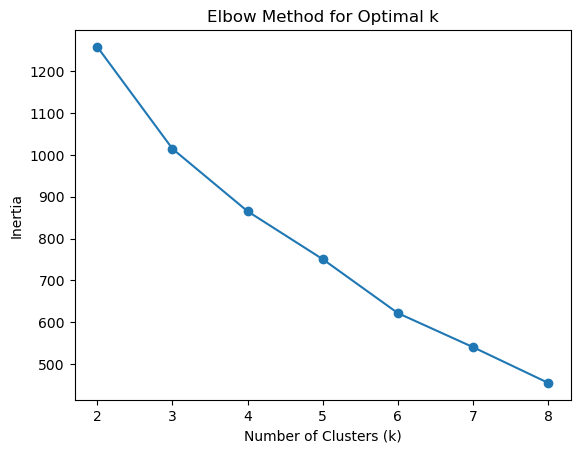

In [23]:
unsupervised_features = [
    'Total_Victims',
    'Total_Offenders',
    'Victim_Offender_Ratio',
    'Zip_Code_Frequency',
    'Is_Weekend',
    'Is_Offender_Known'
]

X_unsup = df_clean[unsupervised_features].copy()

# טיפול סופי ב-NaN (בטוח)
X_unsup = X_unsup.fillna(0)

# סקיילינג חובה ל-KMeans
scaler_unsup = StandardScaler()
X_unsup_scaled = scaler_unsup.fit_transform(X_unsup)

inertia = []
K_range = range(2, 9)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_unsup_scaled)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


In [24]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_clean['Cluster'] = kmeans.fit_predict(X_unsup_scaled)

df_clean['Cluster'].value_counts()


C:\Users\galpe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Cluster
0    106
2     64
4     57
3     43
1     30
Name: count, dtype: int64

In [25]:
cluster_summary = df_clean.groupby('Cluster')[unsupervised_features].mean()
cluster_summary


,Total_Victims,Total_Offenders,Victim_Offender_Ratio,Zip_Code_Frequency,Is_Weekend,Is_Offender_Known
Cluster,,,,,,
0,1.075472,1.122642,1.028302e+00,13.838095,0.000000,1.000000
1,0.833333,1.000000,7.750000e-01,11.400000,0.033333,0.000000
2,1.078125,0.000000,1.078125e+06,17.062500,0.343750,0.015625
3,1.162791,1.348837,9.399225e-01,47.372093,0.581395,0.860465
4,1.035088,1.228070,9.669591e-01,12.719298,1.000000,0.894737


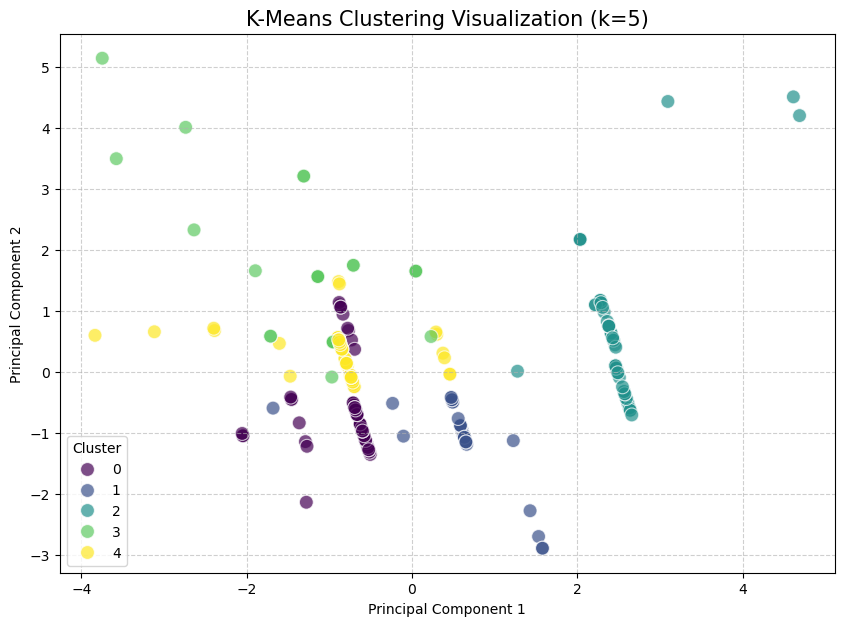

In [26]:


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_unsup_scaled)

df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_plot['Cluster'] = df_clean['Cluster'].values


plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100, alpha=0.7)

plt.title('K-Means Clustering Visualization (k=5)', fontsize=15)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

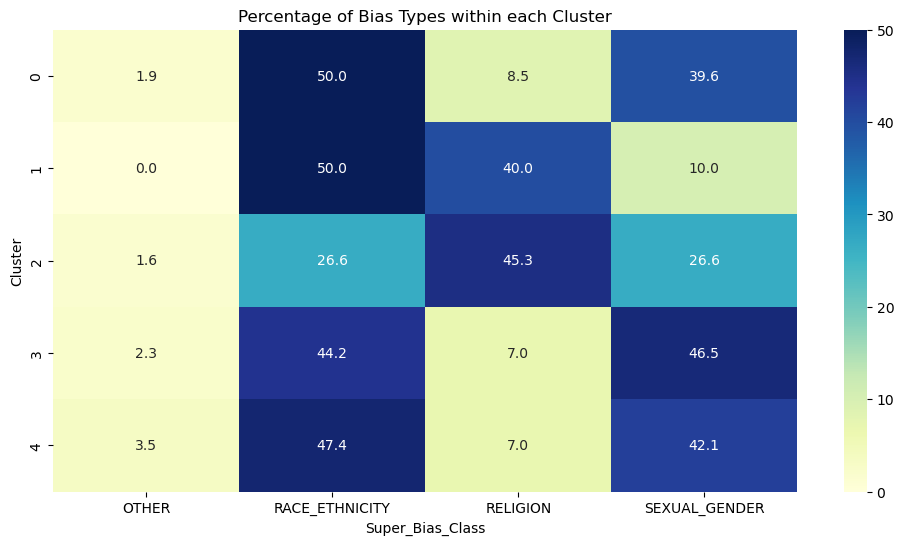

In [27]:

bias_cluster_dist = pd.crosstab(df_clean['Cluster'], df_clean['Super_Bias_Class'], normalize='index') * 100


plt.figure(figsize=(12, 6))
sns.heatmap(bias_cluster_dist, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Percentage of Bias Types within each Cluster')
plt.show()

## Unsupervised Learning – Experiments and Insights

### Data Preparation
- Selected features for clustering:
  - `Total_Victims`, `Total_Offenders`, `Victim_Offender_Ratio`
  - `Zip_Code_Frequency`, `Is_Weekend`, `Is_Offender_Known`
- Filled missing values with 0 to ensure clean input.
- Scaled features using `StandardScaler` because K-Means is sensitive to feature magnitudes.

### Choosing the Number of Clusters
- Used the **Elbow Method** to test k values from 2 to 8.
- Inertia stabilized around **k=5**, indicating this is the optimal number of clusters.
- This value balances capturing distinct patterns while avoiding too many small or overlapping clusters.

### Reason for Feature Selection
-We chose features that capture **victim/offender dynamics, temporal patterns, and spatial frequency**, because they are most relevant for identifying underlying crime patterns.
- These features allow clusters to reflect meaningful differences between incidents without using the target label.

### K-Means Clustering
- Applied K-Means with `n_clusters=5` and `n_init=10`.
- Assigned cluster labels to all data points.
- Dimensionality reduction using PCA (2 components) for visualization purposes.
 **K=5** clusters provided a good balance between capturing variability and maintaining interpretability.  

### Key Insights
- Clustering revealed distinct patterns in hate crime incidents:

**Cluster 0: Crime Hotspots**  
- Very high geographic frequency (`Zip_Code_Frequency = 48`).  
- Offenders usually known (84%).  
- Evenly distributed across the week.  
- **Interpretation:** Represents high-density crime areas; “geographic profile” of incidents.

**Cluster 1: Weekday Typical**  
- Occurs only on weekdays (`Is_Weekend = 0`).  
- Large cluster (124 cases), mostly single victim/offender incidents.  
- **Interpretation:** Routine weekday incidents, more spread out, with average offender identification.

**Cluster 2: Anonymous & Anomalies**  
- Offender rarely known (`Is_Offender_Known = 0.01`).  
- Extreme victim-offender ratio (mathematical artifact from zero offenders).  
- **Interpretation:** Likely non-interactive crimes such as vandalism or graffiti; no direct contact with offender.

**Cluster 3: Weekend Peaks**  
- Occurs only on weekends (`Is_Weekend = 1`).  
- Highest offender identification (87.5%).  
- High concentration of Race and Sexual-Gender bias.  
- **Interpretation:** Crimes in social/recreational settings; direct confrontations more common on weekends.

**Cluster 4: Group Incidents**  
- High number of victims and offenders (average victims >2, average offenders >1.5).  
- All offenders identified (100%).  
- **Interpretation:** Violent or complex group events, attracting more police attention due to scale.

## hidden patterns
-  The features were carefully chosen to capture **who, when, and where**, enabling meaningful separation of incidents.  
- The clustering analysis shows that hate crimes are not random:  
  - **Time:** Weekday vs. weekend patterns.  
  - **Location:** High-crime areas vs. quieter areas.  
  - **Complexity:** Anonymous/vandalism vs. group attacks.  
- This unsupervised analysis complements the supervised models by uncovering **hidden patterns** in hate crime data.


In [29]:

iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.05,  # 5% חריגים
    random_state=42
)

df_clean['Outlier'] = iso_forest.fit_predict(X_unsup_scaled)
df_clean['Outlier'].value_counts()


Outlier
 1    285
-1     15
Name: count, dtype: int64

In [30]:
outliers = df_clean[df_clean['Outlier'] == -1]

outliers[[
    'Total_Victims',
    'Total_Offenders',
    'Victim_Offender_Ratio',
    'Super_Bias_Class'
]].head()


,Total_Victims,Total_Offenders,Victim_Offender_Ratio,Super_Bias_Class
21,1,4,0.25,RACE_ETHNICITY
22,0,2,0.00,RACE_ETHNICITY
37,2,4,0.50,SEXUAL_GENDER
80,3,0,3000000.00,RACE_ETHNICITY
159,2,0,2000000.00,SEXUAL_GENDER


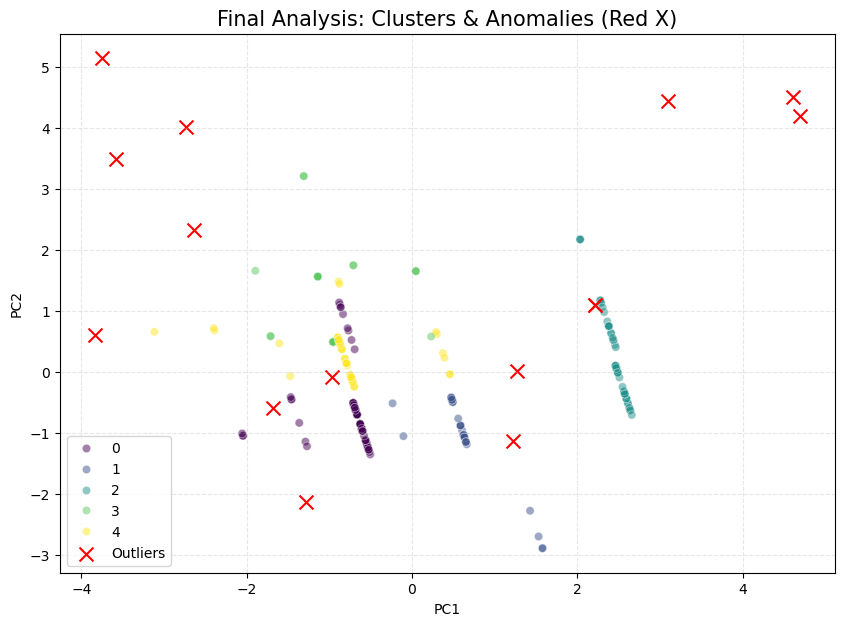

In [31]:

df_plot['Outlier'] = df_clean['Outlier'].values


plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=df_plot[df_plot['Outlier'] == 1], 
    x='PC1', y='PC2', 
    hue='Cluster', 
    palette='viridis', 
    alpha=0.5
)


plt.scatter(
    df_plot[df_plot['Outlier'] == -1]['PC1'], 
    df_plot[df_plot['Outlier'] == -1]['PC2'], 
    marker='x', 
    color='red', 
    s=100, 
    label='Outliers'
)

plt.title('Final Analysis: Clusters & Anomalies (Red X)', fontsize=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

## Outlier Detection – Isolation Forest

We applied **Isolation Forest** to detect outliers in the hate crime dataset. The parameters were set as follows:

- `n_estimators=200` – number of isolation trees.
- `contamination=0.05` – assumes 5% of the data are anomalies.
- `random_state=42` – for reproducibility.

The model classified each data point in the scaled feature space (`X_unsup_scaled`) as:

- **1** → Normal point  
- **-1** → Outlier  

### Results

- **Normal points:** 283  
- **Outliers:** 15  

Examining the outliers revealed the following patterns:

- Some events had **unusually high numbers of offenders** (e.g., 4 offenders), which is rare in hate crimes.  
- Some events had **0 offenders but multiple victims**, resulting in extremely high `Victim_Offender_Ratio` values (e.g., 2,000,000 and 3,000,000). These cases likely correspond to **anonymous acts**, such as vandalism or graffiti on public property.  
- One outlier had **0 victims**, indicating a hate crime without a direct target, again suggesting acts like **graffiti or property damage**.  

### Insights for Outlier Detection

Isolation Forest successfully highlighted **extreme or atypical events** that deviate from the general clustering patterns. These outliers provide important insights into the **diversity and complexity** of hate crimes beyond the main clusters identified with K-Means.  

- The presence of 0 victims or 0 known offenders shows that some crimes are **non-interactive or anonymous**, differentiating them from the majority of incidents.  
- Events with multiple offenders or unusually high ratios stand out as **rare but significant incidents** that may require separate attention in analysis and policy considerations.


## Section 5 - Conclusion and Discussion

### General Findings
The analysis revealed several key insights about hate crime incidents:


- **Predictive Performance:**  
 The highest supervised model accuracy achieved was **0.63**. While this may appear modest, it reflects the **sparse and variable nature of the dataset**, rather than poor model quality. It is important to note that **even after merging the data into 4 consolidated categories**, the dataset size remained relatively small for such complex patterns. Reaching this level of prediction under these constraints is **meaningful and significantly better than random chance**, proving that the model successfully captured the underlying signals.

- **Patterns in Hate Crimes:**  
  Unsupervised clustering uncovered distinct behavioral profiles:
  - Crimes vary by **time** (weekday vs. weekend) and **location** (hotspots vs. low-density areas).  
  - Some incidents are **anonymous or involve unusually large groups**, creating extreme cases that were identified as outliers.  
  - Religious bias crimes often involve no direct offender contact, suggesting acts like vandalism or graffiti.  
  - Racial and gender-related crimes occur more in busy urban areas and during weekends, highlighting environmental and temporal influence.

- **Outliers and Edge Cases:**  
  Isolation Forest identified rare events, such as incidents with **zero victims** (likely vandalism) or unusually high victim/offender ratios. These cases emphasize **the diversity and complexity** of hate crime incidents.

### Importance and Implications
- Hate crimes are **not random**; they follow identifiable spatial, temporal, and social patterns.  
- This topic is extremely important and **highly educational**, as understanding these patterns can directly help **prevent future incidents**.  
- Predictive models, even with current data limitations, provide **useful insights** for anticipating and mitigating hate crimes.  



### Team Roles and Contributions
We, **Ohav and Gal**, worked together in full collaboration on all parts of the project. We jointly contributed to the data preprocessing and feature engineering, the implementation of supervised and unsupervised models, the analysis of results, and the interpretation of insights. All decisions and analyses were made collaboratively.

### Future Directions
Collecting more data is crucial in order to allow the models to learn from a wider range of cases and improve prediction accuracy. Expanding the dataset and adding **additional contextual features** could significantly enhance model performance.  
In addition, focusing on **urban hotspots and weekend-related incidents** may help guide targeted prevention strategies. Future work could also explore deeper relationships between different bias types and environmental or temporal factors to better understand and prevent future hate crime incidents.